In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from joblib import load
import shap
from mplsoccer.pitch import Pitch, VerticalPitch
from mplsoccer.utils import add_image
from sklearn.inspection import permutation_importance
from PIL import Image
from urllib.request import urlopen

Load model and data

In [2]:
cwd = os.getcwd()
df_xgb = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'xgb.parquet'))
df_all = pd.read_parquet(os.path.join(cwd, 'data', 'shots.parquet'))
mask_penalty = (df_all.shot_type_name=='penalty')
df_all = df_all[~mask_penalty].copy()
df_X = df_xgb.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
df_xg_xgb = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'xg_shap_xgb.parquet'))
model_xgb = load(os.path.join(cwd, 'models', 'xgb_model.joblib'))
STATSBOMB = os.path.join(cwd, 'data', 'statsbomb')
df_statsbomb_event = pd.read_parquet(os.path.join(STATSBOMB, 'event.parquet'))
df_statsbomb_freeze = pd.read_parquet(os.path.join(STATSBOMB, 'freeze.parquet'))
df_statsbomb_lineup = pd.read_parquet(os.path.join(STATSBOMB, 'lineup.parquet'))
df_statsbomb_match = pd.read_parquet(os.path.join(STATSBOMB, 'match.parquet'))

Load StatsBomb logos

In [3]:
logo_regular = np.array(Image.open('SB_Regular.png'))
logo_alt = np.array(Image.open('SB_Regular_Alt.png'))

Add Jersey number to freeze frame

In [4]:
df_statsbomb_freeze = df_statsbomb_freeze.merge(df_statsbomb_lineup[['match_id', 'player_id', 'player_jersey_number']],
                                                how='left', on=['match_id', 'player_id'], validate='m:1')

Add on xG to original shots dataframe

In [5]:
df_all = df_all.merge(df_xg_xgb.loc[df_xg_xgb.statsbomb_id.notnull(), ['match_id', 'statsbomb_id', 'xg']], how='left')
df_all = df_all.merge(df_xg_xgb.loc[df_xg_xgb.wyscout_id.notnull(), ['match_id', 'wyscout_id', 'xg']], how='left', 
                      on=['match_id', 'wyscout_id'], suffixes=['', '_1'])
df_all.loc[df_all.xg.isnull(), 'xg'] = df_all.loc[df_all.xg.isnull(), 'xg_1']
df_all.drop(['xg_1'], axis=1, inplace=True)

Add on StatsBomb xG

In [6]:
df_statsbomb_shots = df_statsbomb_event.loc[df_statsbomb_event.type_name == 'Shot', ['id', 'shot_statsbomb_xg']].copy()
df_statsbomb_shots.rename({'id': 'statsbomb_id'}, axis=1, inplace=True)
df_all = df_all.merge(df_statsbomb_shots, left_on='statsbomb_id', right_on='statsbomb_id', how='left')

Compare StatsBomb xG and model

In [7]:
df_all['xg_difference'] = df_all.shot_statsbomb_xg - df_all.xg

In [8]:
df_xg_diff = df_all.loc[df_all['xg_difference'].notnull(), ['x', 'y', 'xg_difference']]

Text(0.5, 1.0, 'Diferencia media absoluta de porcentajes\nentre los xG de StatsBomb y los xG del modelo XGBoost')

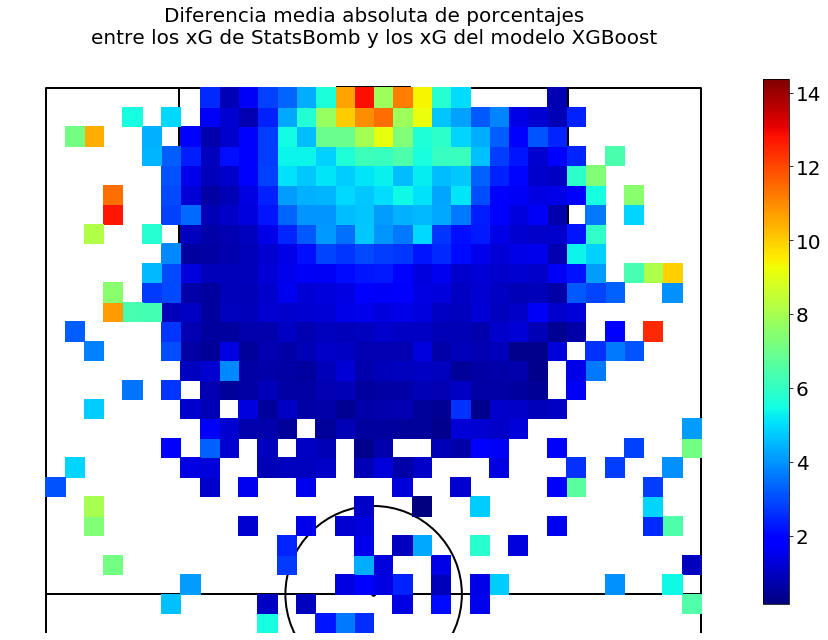

In [9]:
pitch = VerticalPitch(pitch_type='uefa', line_color='black', half=True)
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_xg_diff.x, df_xg_diff.y, values=np.abs(df_xg_diff.xg_difference), statistic='mean', bins=(52, 34))
bs['statistic'] = bs['statistic'] * 100.
pcm = pitch.heatmap(bs, ax=ax, cmap='jet', edgecolors='None')
cbar = fig.colorbar(pcm, fraction=0.1, pad=0.02, shrink=0.9)
cbar.ax.tick_params(labelsize=20)
ax.set_title('Diferencia media absoluta de porcentajes\nentre los xG de StatsBomb y los xG del modelo XGBoost', fontsize=20)

Show where the shots come from.

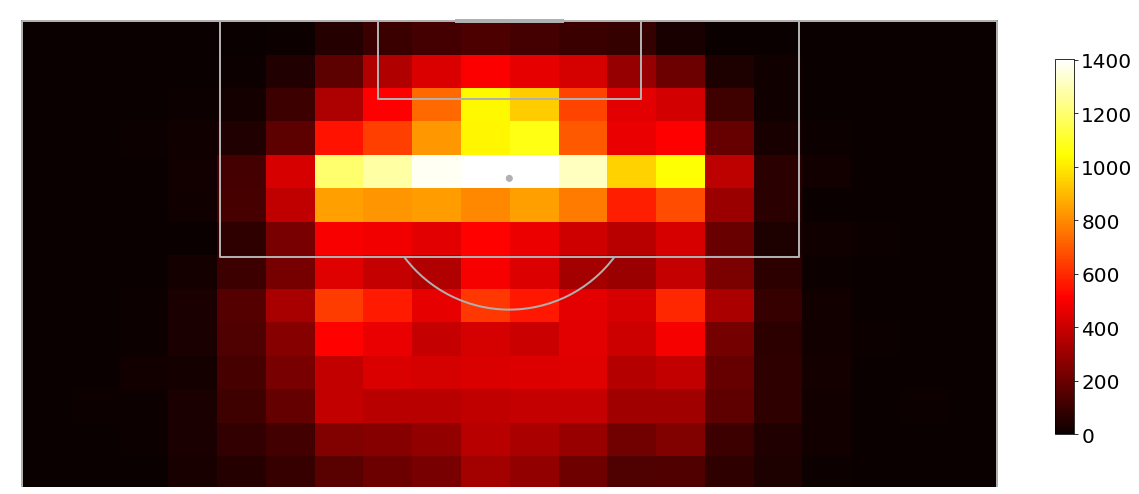

In [11]:
pitch = VerticalPitch(pitch_type='uefa', half=True,
              pad_left=1, pad_right=1, pad_bottom=-20, pad_top=1, line_zorder=2)
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_all.x, df_all.y, statistic='count', bins=(45, 20))
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='None')
cbar = fig.colorbar(pcm, fraction=0.045, pad=0.04, shrink=0.6)
cbar.ax.tick_params(labelsize=20)

Show the probabilities of the shots on the field.

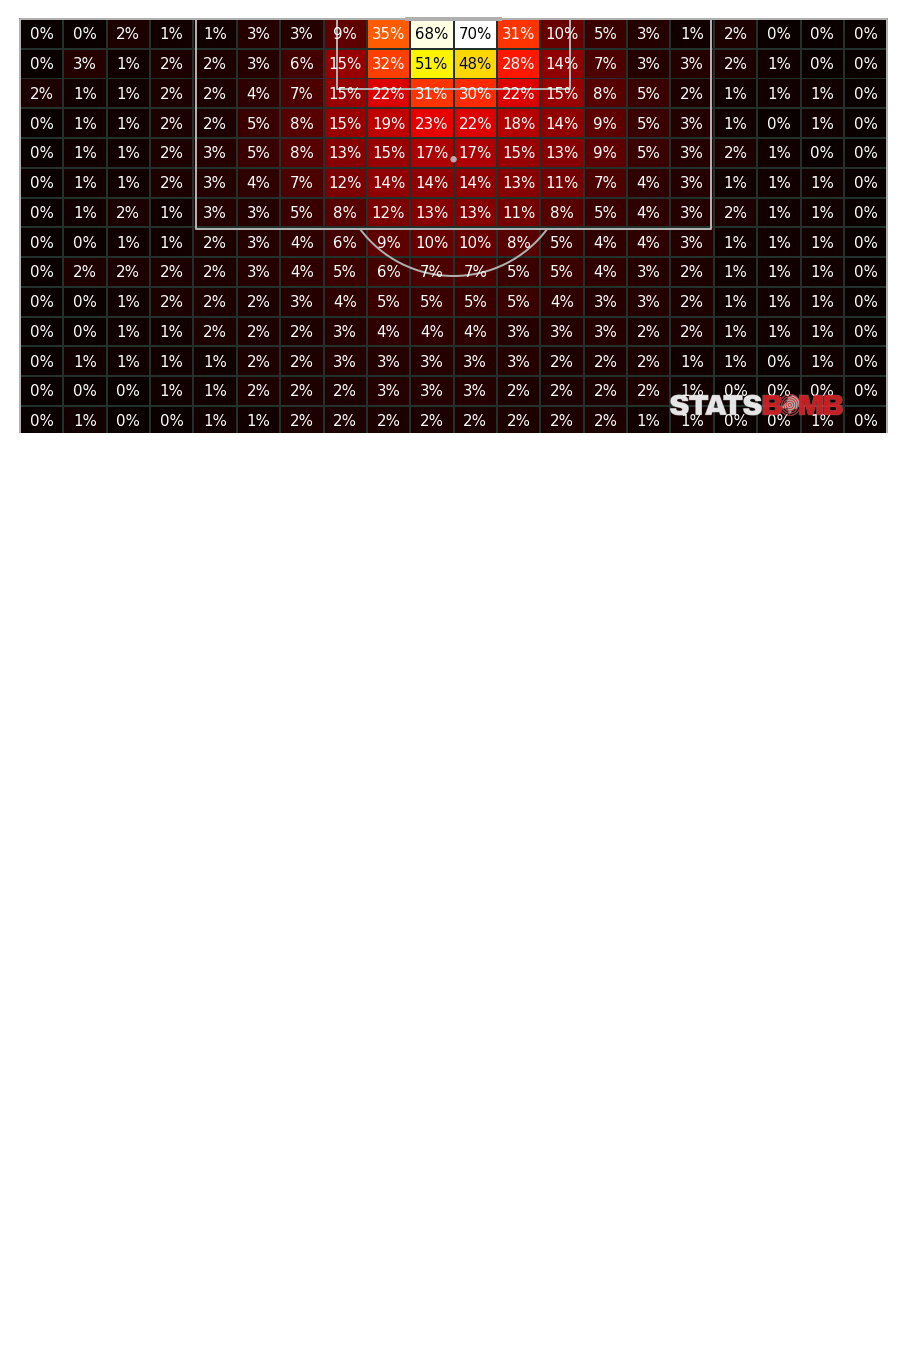

In [12]:
pitch = VerticalPitch(tight_layout=False, pitch_type='uefa', line_zorder=2, half=True, 
              pad_left=1, pad_right=1, pad_bottom=-20, pad_top=1)
fig, ax = pitch.draw(figsize=(16, 9))
bs = pitch.bin_statistic(df_all.x, df_all.y, df_all.xg, statistic='mean', bins=(45, 20))
bs['statistic'] = np.round(np.nan_to_num(bs['statistic']) * 100., 0).astype(np.int32)
vmax = bs['statistic'].max()
pcm = pitch.heatmap(bs, ax=ax, cmap='hot', edgecolors='#22312b')
mask = bs['statistic'] > 40
bs['statistic'] = (pd.DataFrame(bs['statistic']).round(0).astype(np.int32).applymap(lambda x: '{:d}%'.format(x)).values)
annotation = pitch.label_heatmap(bs, color='white', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
bs['statistic'][~mask] = ''
annotation = pitch.label_heatmap(bs, color='black', fontsize=15, ax=ax, ha='center', va='center', zorder=3)
ax_image = add_image(logo_alt, fig, left=0.70, bottom=0.2, width=0.15, alpha=0.9, interpolation='hanning')

Permutation importance and feature importance.

In [13]:
perm_result = permutation_importance(model_xgb,
                                     df_X,
                                     df_xgb.goal,
                                     n_repeats=10,
                                     random_state=42,
                                     n_jobs=-1)

In [14]:
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])

df_perm_importance = pd.DataFrame({'Feature': features,
                                   'importance': perm_result.importances.mean(axis=1),
                                   'std_dev': perm_result.importances.std(axis=1)})
df_perm_importance.sort_values('importance', ascending=False, inplace=True)
df_perm_importance.reset_index(drop=True, inplace=True)

In [15]:
df_perm_importance

,Feature,importance,std_dev
0,visible angle,0.005280,0.000108
1,distance to goal,0.003742,0.000204
2,body part name,0.000991,0.000219
3,goalkeeper x,0.000972,0.000287
4,n angle,0.000460,0.000209
5,shot type name,0.000429,0.000201
6,shot open goal,0.000268,0.000154
7,area goal,0.000240,0.000068
8,pass technique name,0.000200,0.000041
9,x,0.000183,0.000078


Text(0.5, 0, 'Importancia de la variable * 10000')

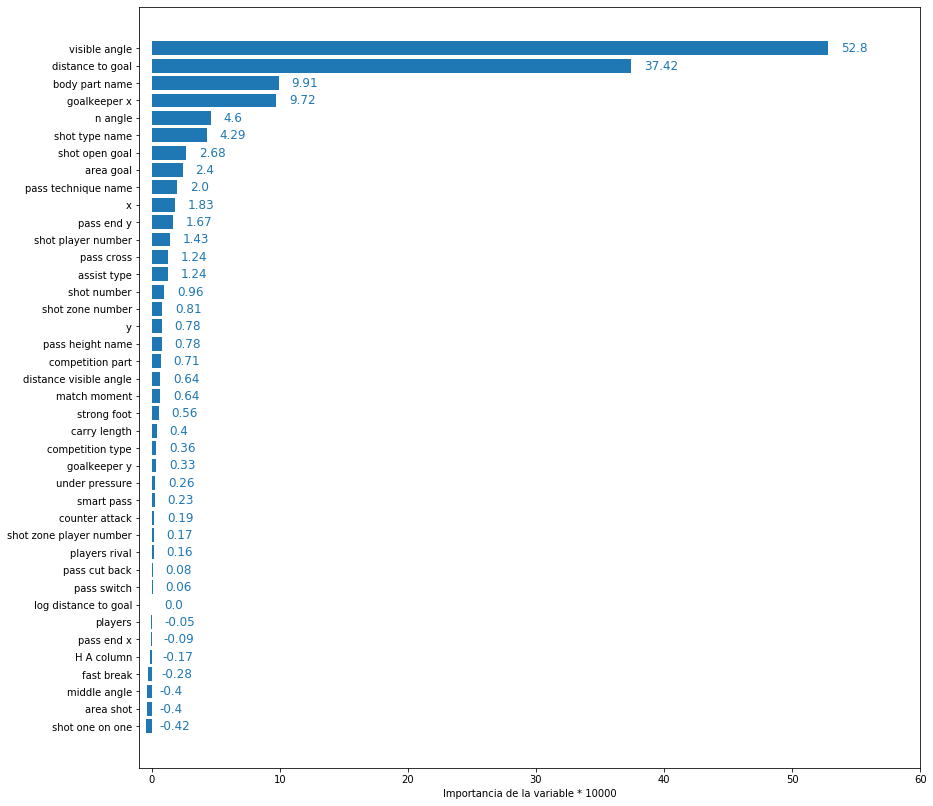

In [16]:
fig, ax = plt.subplots(figsize=(14, 14))
sorted_idx = perm_result.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_result.importances_mean[sorted_idx]*10000, color ='tab:blue')
y = perm_result.importances_mean[sorted_idx]*10000
y = y.round(2)
plt.xlim(-1, 60)
for i, v in enumerate(y):
    ax.text(v+1, i, str(v), color='tab:blue', va = 'center', size = 12)
plt.xlabel("Importancia de la variable * 10000")

Text(0.5, 0, 'Permutation importance')

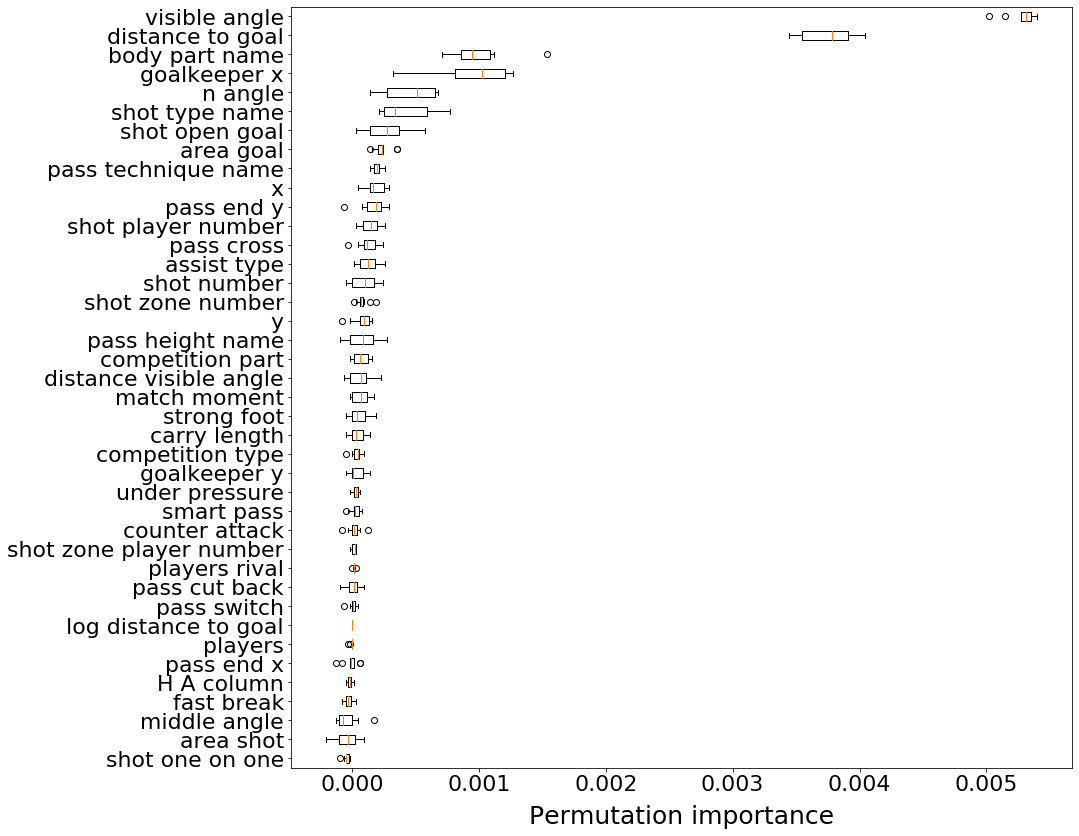

In [17]:
fig, ax = plt.subplots(figsize=(14, 14))
sorted_idx = perm_result.importances_mean.argsort()
box_plot = ax.boxplot(perm_result.importances[sorted_idx].T, vert=False, labels=features[sorted_idx])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_xlabel('Permutation importance', labelpad=10, fontsize=25)

Shap values

Filter only StatsBomb and add goalkeeper id

In [18]:
df_xg_xgb = df_xg_xgb.loc[df_xg_xgb['statsbomb_id'].notnull()].copy()
df_xg_xgb = df_xg_xgb.merge(df_all.loc[df_all.statsbomb_id.notnull(), ['statsbomb_id']],
                    how='left', on='statsbomb_id', validate='1:1')
df_xg_xgb.drop('wyscout_id', axis=1, inplace=True)

Add nickname

In [19]:
df_statsbomb_lineup = df_statsbomb_lineup[['player_id', 'player_nickname']]
df_statsbomb_lineup.sort_values('player_nickname', inplace=True)
mask_nickname = df_statsbomb_lineup.player_nickname.isnull()
df_statsbomb_lineup.drop_duplicates('player_id', keep='first', inplace=True)

Dataframe of nicknames

In [20]:
df_statsbomb_event['outcome_name'] = df_statsbomb_event.outcome_name.replace({'Off T': 'Off Target'})

Add Shap values for goalkeeper position

In [21]:
df_xg_xgb['gk_contribution'] = df_xg_xgb[['goalkeeper x', 'goalkeeper y']].sum(axis=1).sort_values()

Sort values by contribution

In [22]:
df_xg_xgb.sort_values('gk_contribution', inplace=True)

In [23]:
idx = -6

In [24]:
shot_id = df_xg_xgb.iloc[idx].statsbomb_id
df_single_shot = df_statsbomb_event[df_statsbomb_event.id == shot_id].copy()
df_single_shot = df_single_shot.merge(df_statsbomb_lineup, how='left', on='player_id')
df_single_frame = df_statsbomb_freeze[df_statsbomb_freeze.id == shot_id].copy()
df_single_frame = df_single_frame.merge(df_statsbomb_lineup, how='left', on='player_id')

In [25]:
df_teammate = df_single_frame[df_single_frame.player_teammate].copy()
df_gk = df_single_frame[(~df_single_frame.player_teammate) & 
                        (df_single_frame.player_position_name == 'Goalkeeper')].copy()
df_other = df_single_frame[(~df_single_frame.player_teammate) & 
                           (df_single_frame.player_position_name != 'Goalkeeper')].copy()
outcome = df_single_shot.outcome_name.values[0]
team_name = df_single_shot.team_name.values[0]
player_name = df_single_shot.player_nickname.values[0]
if player_name is None:
    player_name = df_single_shot.player_name.values[0]
gk_name = df_gk.player_nickname.values[0]
if gk_name is None:
    gk_name = df_gk.player_name.values[0]
match_id = df_single_shot.match_id.values[0]

In [26]:
home_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].home_team_name.values[0]
away_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].away_team_name.values[0]
date = df_statsbomb_match[df_statsbomb_match.match_id == match_id].match_date.values[0].astype('str')[:10]
if home_team == team_name:
    other_team = away_team
else:
    other_team = home_team

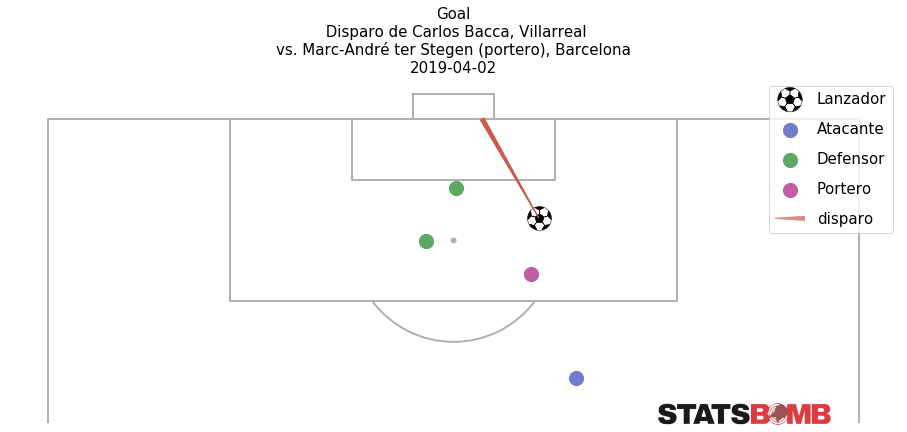

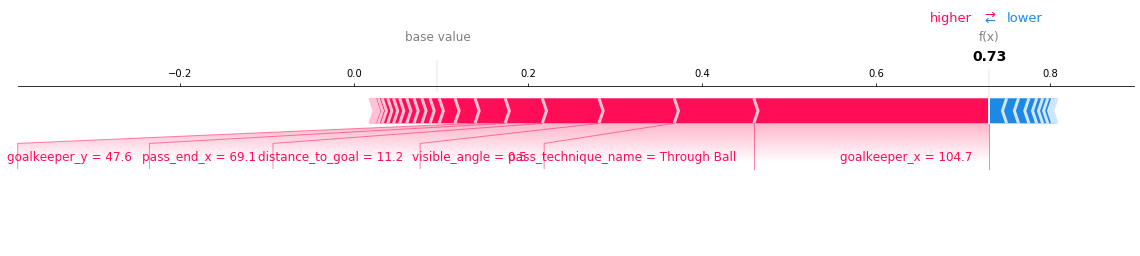

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))
pitch = VerticalPitch(half=True, tight_layout=False, goal_type='box', pad_bottom=-30)
pitch.draw(ax=ax)
ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.2, width=0.15, alpha=0.9, interpolation='hanning')
sc1 = pitch.scatter(df_single_shot.x, df_single_shot.y, marker='football', s=600, ax=ax, label='Lanzador', zorder=1.2)
sc2 = pitch.scatter(df_teammate.x, df_teammate.y, s=200, c='#727cce', label='Atacante', ax=ax)
sc3 = pitch.scatter(df_other.x, df_other.y, s=200, c='#5ba965', label='Defensor', ax=ax)
sc4 = pitch.scatter(df_gk.x, df_gk.y, s=200, ax=ax, c='#c15ca5', label='Portero')
line = pitch.lines(df_single_shot.x, df_single_shot.y, 
                   df_single_shot.end_x, df_single_shot.end_y,
                   comet=True, label='disparo', color='#cb5a4c', ax=ax)
legend = ax.legend(labelspacing=1, fontsize=15)
title = (f'{outcome}\n Disparo de {player_name}, {team_name}\n'
         f'vs. {gk_name} (portero), {other_team}\n'
         f'{date}')
ax.set_title(title, fontsize=15)
features = df_all.loc[df_all.statsbomb_id == shot_id, df_X.columns]
float_cols = ['distance_to_goal','visible_angle','pass_end_x', 'pass_end_y', 'carry_length', 'area_shot',
              'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']
features[float_cols] = features[float_cols].round(1)
shap.force_plot(df_xg_xgb.loc[df_xg_xgb.statsbomb_id == shot_id, df_xg_xgb.columns[-2]].values[0], 
                df_xg_xgb.loc[df_xg_xgb.statsbomb_id == shot_id, df_xg_xgb.columns[3:-2]].values,
                features=features.astype(str),
                feature_names=df_X.columns, matplotlib=True)

In [28]:
df_all.loc[df_all.statsbomb_id == shot_id, ['shot_statsbomb_xg', 'xg', 'xg_difference']]

,shot_statsbomb_xg,xg,xg_difference
18332,0.773499,0.730028,0.043471


In [29]:
idx = 55

In [30]:
shot_id = df_xg_xgb.iloc[idx].statsbomb_id
df_single_shot = df_statsbomb_event[df_statsbomb_event.id == shot_id].copy()
df_single_shot = df_single_shot.merge(df_statsbomb_lineup, how='left', on='player_id')
df_single_frame = df_statsbomb_freeze[df_statsbomb_freeze.id == shot_id].copy()
df_single_frame = df_single_frame.merge(df_statsbomb_lineup, how='left', on='player_id')

In [31]:
df_teammate = df_single_frame[df_single_frame.player_teammate].copy()
df_gk = df_single_frame[(~df_single_frame.player_teammate) & 
                        (df_single_frame.player_position_name == 'Goalkeeper')].copy()
df_other = df_single_frame[(~df_single_frame.player_teammate) & 
                           (df_single_frame.player_position_name != 'Goalkeeper')].copy()
outcome = df_single_shot.outcome_name.values[0]
team_name = df_single_shot.team_name.values[0]
player_name = df_single_shot.player_nickname.values[0]
if player_name is None:
    player_name = df_single_shot.player_name.values[0]
gk_name = df_gk.player_nickname.values[0]
if gk_name is None:
    gk_name = df_gk.player_name.values[0]
match_id = df_single_shot.match_id.values[0]

In [32]:
home_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].home_team_name.values[0]
away_team = df_statsbomb_match[df_statsbomb_match.match_id == match_id].away_team_name.values[0]
date = df_statsbomb_match[df_statsbomb_match.match_id == match_id].match_date.values[0].astype('str')[:10]
if home_team == team_name:
    other_team = away_team
else:
    other_team = home_team

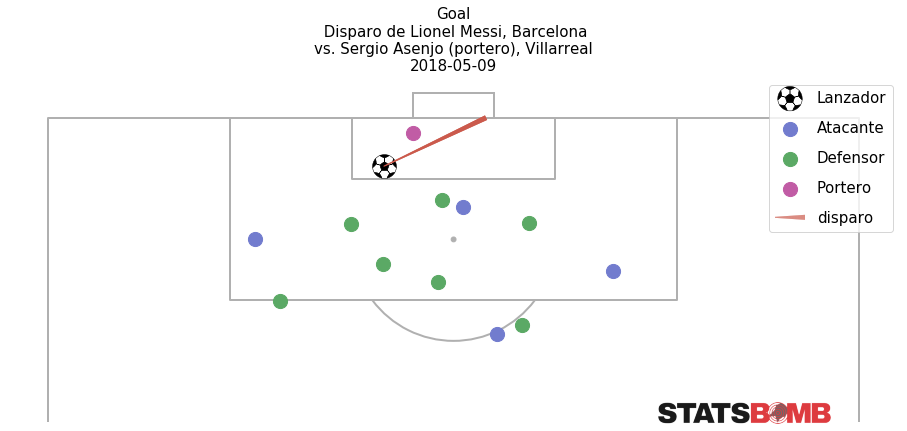

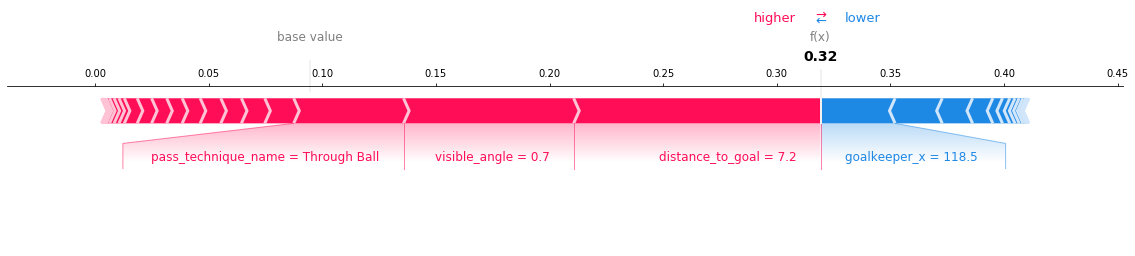

In [33]:
fig, ax = plt.subplots(figsize=(16, 8))
pitch = VerticalPitch(half=True, tight_layout=False, goal_type='box', pad_bottom=-30)
pitch.draw(ax=ax)
ax_image = add_image(logo_regular, fig, left=0.69, bottom=0.2, width=0.15, alpha=0.9, interpolation='hanning')
sc1 = pitch.scatter(df_single_shot.x, df_single_shot.y, marker='football', s=600, ax=ax, label='Lanzador', zorder=1.2)
sc2 = pitch.scatter(df_teammate.x, df_teammate.y, s=200, c='#727cce', label='Atacante', ax=ax)
sc3 = pitch.scatter(df_other.x, df_other.y, s=200, c='#5ba965', label='Defensor', ax=ax)
sc4 = pitch.scatter(df_gk.x, df_gk.y, s=200, ax=ax, c='#c15ca5', label='Portero')
line = pitch.lines(df_single_shot.x, df_single_shot.y, 
                   df_single_shot.end_x, df_single_shot.end_y,
                   comet=True, label='disparo', color='#cb5a4c', ax=ax)
legend = ax.legend(labelspacing=1, fontsize=15)
title = (f'{outcome}\n Disparo de {player_name}, {team_name}\n'
         f'vs. {gk_name} (portero), {other_team}\n'
         f'{date}')
ax.set_title(title, fontsize=15)
features = df_all.loc[df_all.statsbomb_id == shot_id, df_X.columns]
float_cols = ['distance_to_goal','visible_angle','pass_end_x', 'pass_end_y', 'carry_length', 'area_shot',
              'area_goal', 'n_angle', 'goalkeeper_x', 'goalkeeper_y']
features[float_cols] = features[float_cols].round(1)
shap.force_plot(df_xg_xgb.loc[df_xg_xgb.statsbomb_id == shot_id, df_xg_xgb.columns[-2]].values[0], 
                df_xg_xgb.loc[df_xg_xgb.statsbomb_id == shot_id, df_xg_xgb.columns[3:-2]].values,
                features=features.astype(str),
                feature_names=df_X.columns, matplotlib=True)

In [34]:
df_all.loc[df_all.statsbomb_id == shot_id, ['shot_statsbomb_xg', 'xg', 'xg_difference']]

,shot_statsbomb_xg,xg,xg_difference
9697,0.330551,0.31924,0.011311
